# Distributed system optimization

Tho objective of this code is to develope an environment for the simulation of different distributed networks.
These networks are composed of clouds, edges, volunteers and a local device.
The simulation environment generates a set of tasks that must be divided between the devices for the computation according to some rule (e.g. minimize the execution time, minimize the energy consumption, etc.).



**Units system**

Throughout this code, we will always use the following units:

* [CPUspeed] = MHz

* [Distances] = m

* [Time] = s

* [CPUcycles] = million CPU cycles

* [Memory] = Mb

* [bandwidth] = Mbit / s




## Libraries import and global variables

In [1]:
import numpy as np
import datetime
import copy
import plotly.express as px
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import random

In [2]:
# Global variables
volunteerTrustTreshold = 0.3
simulationLength = 3600 * 6 #[seconds]
volunteerTimeoutTreshold = datetime.timedelta(seconds=simulationLength * .1)
transitionCoefficient = 1 # Coefficient for transforming energy cost into time cost

## General unit
This class is the parent class for all the devices (cloud, edge, vlounteer and localDevice).

In [3]:
class GeneralUnit:
  __slots__ = ['name', 'location', 'capacity', 'costRate', 'connection', 'energy']

  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)
    self.transmissionPower = 10 #[dBm]
    self.transmissionPower = 10**(self.transmissionPower/10) # [mW]
    self.fadingCoeff = 0.7
    self.noisePower  = 0.008 * self.transmissionPower * \
      self.fadingCoeff * self.fadingCoeff # [mW]
    self.pathLossExponent = 2.5

    # The endTime of a unit is the time at which it finished its last job
    self.endTime = datetime.datetime.now()
    self.log = {'taskIDs':[], 'taskExecutionTime':[], 'taskArrivalTime':[],
                'taskEndTime':[]}



  def computeExecutionTime(self, _task, considerEnergy = True):
    computationTime = _task.CPUcycles / self.capacity['CPUspeed']
    dataTransferTime = 0
    if self.getType() != "myDevice":
      dataTransferTime = _task.memorySize / self.connection['bandwidth'] \
        + self.connection['latency']


    totalEnergy = 0


    if considerEnergy:

      computationEnergy = computationTime * self.energy['CPUEnergy'] / 3600

      dataTransferEnergy = 0
      if self.getType() != "myDevice":
        dataTransferEnergy = _task.memorySize * self.energy['bandwidthEnergy'] \
                              * dataTransferTime / 3600

      totalEnergy  = dataTransferEnergy + computationEnergy

      #print("\n dataTransferEnergy: ", dataTransferEnergy , "    computationEnergy",  computationEnergy)

    totalEnergy = transitionCoefficient * totalEnergy

    #print("\n totalEnergy: ", totalEnergy, "    computationTime", computationTime)

    return datetime.timedelta(seconds=computationTime + dataTransferTime + \
                              self.getWirelessTransferTime(_task.memorySize) +\
                              totalEnergy)


  def getWirelessTransferTime(self, _taskMemorySize):
      wirelessTransferTime = 0 #[s]
      if self.location > 0.0:
        wirelessTransferTime = self.connection['bandwidth'] * \
          np.log2(1 + (self.transmissionPower * self.fadingCoeff * \
                      self.fadingCoeff) / (self.noisePower * \
                                          self.location**self.pathLossExponent))
      return wirelessTransferTime



  def assignTask(self, _task):
    execTime = self.computeExecutionTime(_task)

    if self.endTime < _task.arrivalTime: # unit queue is empty
       self.endTime = _task.arrivalTime + execTime
    else: # the tasks goes in the queue
      self.endTime = self.endTime + execTime

    taskStartTime = self.endTime - execTime
    _task.assign(taskStartTime, self.endTime, self.name)
    if _task.endTime <= _task.startTime:
      raise TypeError("The task computation of exeTime went wrong")

    self.append2log(_task.id, _task.getExecutionTime(), _task.arrivalTime,
                    _task.endTime)

  def append2log(self, _taskID, _taskExecutionTime, _taskArrivalTime,
                _taskEndTime):
    self.log['taskIDs'].append(_taskID)
    self.log['taskExecutionTime'].append(_taskExecutionTime)
    self.log['taskArrivalTime'].append(_taskArrivalTime)
    self.log['taskEndTime'].append(_taskEndTime)

  def printLog(self):
    print("Log of unit: ", self.name)
    print("Unit type: ", self.getType())
    print("Assigned tasks: ",  self.log['taskIDs'])

  def getType(self):
    return 'General unit'


### Could

In [4]:
class Cloud(GeneralUnit):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def getType(self):
    return 'cloud'


### Edge

In [5]:
class Edge(GeneralUnit):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def getType(self):
    return 'edge'

### Volunteer

In [6]:
class Volunteer(GeneralUnit):
  def __init__(self, _trust, _availability, **kwargs):
    super().__init__(**kwargs)
    self.trust = _trust
    self.availability = _availability
    self.NexecutedTasks = 0
    self.lastShutdownTime = datetime.datetime.now()

  def getType(self):
    return 'volunteer'

  def shutDown(self, _shutDownTime = datetime.datetime.now()):
    self.availability = 0
    self.lastShutdownTime = _shutDownTime
    notExecutedTasksID = []
    for taskI in range(len(self.log['taskIDs'])):
      if(self.log['taskEndTime'][taskI] >= _shutDownTime):
        notExecutedTasksID = self.log['taskIDs'][taskI:]
        del self.log['taskIDs'][taskI:]
        del self.log['taskExecutionTime'][taskI:]
        del self.log['taskArrivalTime'][taskI:]
        del self.log['taskEndTime'][taskI:]
        break
    NcurrentExecutedTasks = len(self.log['taskIDs']) - self.NexecutedTasks
    NnotExecutedTasks = len(notExecutedTasksID)
    self.NexecutedTasks = len(self.log['taskIDs'])

    self.trust = self.trust * (NcurrentExecutedTasks + 2) / \
      (NnotExecutedTasks + NcurrentExecutedTasks + 2)
    return notExecutedTasksID

  def turnOn(self):
    self.availability = 1

  def restoreTrust(self):
    self.trust = 0.5

  # The untrusted time is the time passed between the last shutdown and the
  # current time
  def getUntrustedTime(self, _time):
    return _time - self.lastShutdownTime


### Local device

In [7]:
class LocalDevice(GeneralUnit):
  def __init__(self, **kwargs):
    kwargs['name'] = "myDevice"
    kwargs['location'] = 0
    kwargs['costRate'] = 0
    super().__init__(**kwargs)

  def getType(self):
    return 'localDevice'

## Tasks class

In [8]:
class Task:
  __slots__ = ['id', 'type', 'priority', 'arrivalTime', 'deadlineTime',
               'delayTolerance', 'CPUcycles', 'memorySize', 'incentive',
               'startTime', 'endTime', 'wastedTime',
               'assignedUnit', 'successFlag', 'assignmentCounter']

  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)
    self.wastedTime = datetime.timedelta(seconds=0.0)
    self.successFlag = True
    self.assignmentCounter = 0

  def setArrivalTime(self, _arrival):
    self.arrivalTime = _arrival

  def setStartTime(self, _start):
    self.startTime = _start

  def setEndTime(self, _end):
    self.endTime = _end

  def setUnitName(self, _name):
    self.assignedUnit = _name

  def assign(self, _startTime, _endTime, _unitName):
    self.assignmentCounter = self.assignmentCounter + 1
    self.setStartTime(_startTime)
    self.setEndTime(_endTime)
    self.setUnitName(_unitName)

  def notAssigned(self):
    self.successFlag = False
    self.endTime = datetime.datetime(1, 1, 1, 0, 0)
    self.assignedUnit = "None"

  def prepareForReassignment(self, _reassignmentTime):
    self.wastedTime = self.wastedTime + _reassignmentTime - self.arrivalTime
    self.arrivalTime = _reassignmentTime
    self.assignedUnit = "None"
    self.startTime = None
    self.endTime = None

  def getExecutionTime(self):
    if self.assignedUnit == "None":
      raise TypeError("Cannot call this funcion because this task was not assigned")
    return self.endTime - self.startTime

  def getQueingTime(self):
    if self.assignedUnit == "None":
      raise TypeError("Cannot call this funcion because this task was not assigned")
    return self.startTime - self.arrivalTime + self.wastedTime

  def print(self):
    print('\nTask ID = ', self.id)
    print('Arrival time = ', self.arrivalTime - self.wastedTime )
    print('Start time = ', self.startTime)
    print('Queing time = ', self.getQueingTime(), 's')
    print('Execution time = ', self.getExecutionTime(), 's')
    print('End time = ', self.endTime)
    print('Assigned unit = ', self.assignedUnit)
    print('Success = ', self.successFlag)

In [9]:
def randomTaskGenerator(_Ntasks):
  tasks = []
  for taskI in  range(_Ntasks):
    priority = np.random.uniform(0, 20)
    delayTolerance = np.random.uniform(0, 1)
    incentive = np.random.uniform(0.1, 1)
    minDeadline = 60 * 5 #[s]
    maxDeadline = 60 * 40 #[s]
    deadlineTime = np.random.uniform(minDeadline, maxDeadline)
    CPUcycles = np.random.uniform(deadlineTime / 10 * 1000,
                                  deadlineTime / 2 * 1000)
    memorySize = np.random.uniform(1, 10)
    arrivalTime = datetime.datetime.now() + \
      datetime.timedelta(seconds=np.random.uniform(0, simulationLength))
    deadlineTime = arrivalTime + \
      datetime.timedelta(seconds=deadlineTime)

    task_dict = {'id':taskI, 'type':'imageProcessing', 'priority':priority,
                  'arrivalTime':arrivalTime,
                  'deadlineTime':deadlineTime,
                  'delayTolerance':delayTolerance,
                  'CPUcycles':CPUcycles, 'memorySize':memorySize,
                  'incentive':incentive}

    task = Task(**task_dict)
    tasks.append(task)
  return tasks

## Network class
To contruct a network we need a list of colouds, one of edges, one of volunteers and a local device. The units are then collected alltogether into the `units` dictionary.
It is also possible to add units to the network after the construction by using `addUnit`.




In [10]:
class Network:
  def __init__(self, _clouds, _edges, _volunteers, _localDevice):
    self.units = {}
    for unitTypeI in [_clouds, _edges, _volunteers, [_localDevice]]:
      for unitI in unitTypeI:
        self.units[unitI.name] = unitI

  def addUnit(self, _unit):
    self.units[_unit.name] = _unit

  def generateRandomVolunteers(self, _Nvolunteers):
    for volunteerI in range(_Nvolunteers):
      name = 'volunteer_'+str(volunteerI)
      self.generateRandomVolunteer(name)

  def generateRandomVolunteer(self, _name):
    location = np.random.uniform(10, 50)
    CPUspeed = np.random.uniform(1000, 2500)
    bandwidth = np.random.uniform(50, 100)
    latency = np.random.uniform(.001, .01)
    costRate = 'dummyCostRate'
    trust = 1
    availability = 1
    CPUEnergy = np.random.uniform(75, 125) #Wh
    bandwidthEnergy = np.random.uniform(100, 150) #Wh per Mbyte



    volunteer_dict = {'name':_name, 'location':location,
                  'capacity':{'CPUspeed':CPUspeed},
                  'costRate':costRate,
                  'connection':{'bandwidth':bandwidth,'latency':latency},
                  'energy':{'CPUEnergy':CPUEnergy,
                            'bandwidthEnergy':bandwidthEnergy}
                    }
    volunteer = Volunteer(trust, availability, **volunteer_dict)
    self.addUnit(volunteer)

  def print(self):
    print("\nNetwork structure:")
    for unitNameI in self.units:
      print(unitNameI)
      if self.units[unitNameI].getType() == "volunteer":
        print("\tAvailability = ", self.units[unitNameI].availability)
        print("\tTrust = ", self.units[unitNameI].trust)

In [11]:
# This function randomly generates a network given the number of clouds and edges
# The resulting network will not have volunteers.
# To randomly generate volunteers, call the
# generateRandomVolunteers(Nvolunteers) member of the network class
def randomNetworkGenerator(_Nclouds, _Nedges):
    clouds = []
    edges = []

    for cloudI in range(_Nclouds):
      name = 'cloud_'+str(cloudI)
      location = np.random.uniform(50, 100)
      CPUspeed = np.random.uniform(3600, 3900)
      bandwidth = np.random.uniform(50, 100)
      latency = np.random.uniform(.01, .08)
      costRate = 'dummyCostRate'

      CPUEnergy = np.random.uniform(100, 150) #Wh
      bandwidthEnergy = np.random.uniform(175, 225) #Wh per Mbyte


      cloud_dict = {'name':name, 'location':location,
                    'capacity':{'CPUspeed':CPUspeed},
                    'costRate':costRate,
                    'connection':{'bandwidth':bandwidth,'latency':latency},
                    'energy':{'CPUEnergy':CPUEnergy,
                              'bandwidthEnergy':bandwidthEnergy}
                    }
      cloud = Cloud(**cloud_dict)
      clouds.append(cloud)

    for edgeI in range(_Nedges):
      name = 'edge_'+str(edgeI)
      location = np.random.uniform(10, 50)
      CPUspeed = np.random.uniform(2200, 3500)
      bandwidth = np.random.uniform(50, 100)
      latency = np.random.uniform(.001, .01)
      costRate = 'dummyCostRate'
      CPUEnergy = np.random.uniform(75, 150) #Wh
      bandwidthEnergy = np.random.uniform(150, 200) #Wh per Mbyte



      edge_dict = {'name':name, 'location':location,
                    'capacity':{'CPUspeed':CPUspeed},
                    'costRate':costRate,
                    'connection':{'bandwidth':bandwidth,'latency':latency},
                    'energy':{'CPUEnergy':CPUEnergy,
                              'bandwidthEnergy':bandwidthEnergy}
                    }
      edge = Edge(**edge_dict)
      edges.append(edge)

    CPUspeed = np.random.uniform(1000, 2000)
    bandwidth = np.random.uniform(10, 50)
    latency = 0
    CPUEnergy = np.random.uniform(75, 125) #Wh
    bandwidthEnergy = np.random.uniform(75, 125) #Wh per Mbyte
    local_dict = {'capacity':{'CPUspeed':CPUspeed},
                  'connection':{'bandwidth':bandwidth, 'latency':latency},
                  'energy':{'CPUEnergy':CPUEnergy,
                              'bandwidthEnergy':bandwidthEnergy}
                  }
    local = LocalDevice(**local_dict)

    return Network(clouds, edges, [], local)

## Simulation environment
We now set up the simulation environment.

### Runtime control class
The runtime control is a smart log that we developed to keep track of the assigned tasks and the related units

In [12]:
class RuntimeControl:
  def __init__(self):
    self.assignedTasks = []
    self.units = []
    self.taskIndex = []
    self.notAssignedTasks = []

  def appendAssignedTask(self, _task, _device):
    self.assignedTasks.append(_task)
    self.units.append(_device)
    self.taskIndex.append(tuple([_task.id, len(self.assignedTasks)]))

  def appendNotAssignedTask(self, _task):
    self.notAssignedTasks.append(_task)

  def restart(self):
    self.assignedTasks = []
    self.units = []
    self.taskIndex = []
    self.notAssignedTasks = []

  def print(self):
    print("Runtime control:")
    print("\n**************************")
    print("Assigned tasks:\n")
    unitI = 0
    for taskI in self.assignedTasks:
      print("Task ID = ", taskI.id)
      print("Assigned to unit: ", self.units[unitI])
      print("Arrival time = ", taskI.arrivalTime)
      print("StartTime = ", taskI.startTime)
      print("EndTime = ", taskI.endTime)
      print("Assigned %d times" % taskI.assignmentCounter)
      print("\n")
      unitI = unitI + 1

    print("\n**************************")
    print("Not assigned tasks:\n")
    for taskI in self.notAssignedTasks:
      print("Task ID = ", taskI.id)
      print("Assigned %d times" % taskI.assignmentCounter)
      print("\n")

  def getNotAssignedTasks(self):
    return len(self.notAssignedTasks)



### Simulation class

The simulation if composed of a network, a  set of tasks and a rule for assigning the tasks to the different units of the network.

In [13]:
def taskSorting(_task):
  return _task.arrivalTime.timestamp()

class Simulation:
  def __init__(self, _network, _tasks, _optimizationGoal):
    self.network = _network
    self.tasks = _tasks
    self.tasks.sort(key=taskSorting)
    self.optimizationGoal = _optimizationGoal
    self.runtimeControl = RuntimeControl()
    self.notAssignedTasks = []

  def getBestDevice(self, _task):
    executionTimeMin = _task.arrivalTime + \
      datetime.timedelta(days=10000) # Just a big number
    bestDevice = 'None'
    success = False
    startTime = None
    for unitI in self.network.units:
      if self.network.units[unitI].getType() == "volunteer":
        if self.network.units[unitI].availability == 0:
          continue
        else:
          if self.volunteerTrustCheck(unitI, _task.arrivalTime) == 0:
            continue
      exeT = self.network.units[unitI].computeExecutionTime(_task)
      startTime = max(self.network.units[unitI].endTime, _task.arrivalTime)
      endTime = startTime + exeT
      if _task.deadlineTime > endTime:
        if endTime < executionTimeMin:
          executionTimeMin = endTime
          bestDevice = unitI
          success = True
    return bestDevice, success

  def volunteerTrustCheck(self, _unitName, _currentTime):
    # Check if the volunteer trust is below volunteerTrustTreshold and then if
    # it has been shut down for a time longer than volunteerTimeoutTreshold
    flag = 1
    if self.network.units[_unitName].trust < volunteerTrustTreshold:
      if self.network.units[_unitName].getUntrustedTime(_currentTime) > volunteerTimeoutTreshold:
        self.network.units[_unitName].restoreTrust()
      flag = 0
    return flag

  def shutDownVolunteer(self, _volunteerName, _shutDownTime):
    toReassignTasksIDs = self.network.units[_volunteerName].shutDown(_shutDownTime)
    for taskID in toReassignTasksIDs:
      task = [x for x in self.tasks if x.id == taskID][0]
      task.prepareForReassignment(_shutDownTime)
      bestDevice, success = self.getBestDevice(task)
      if success:
        self.network.units[bestDevice].assignTask(task)
        self.runtimeControl.appendAssignedTask(task, bestDevice)
      else:
        self.runtimeControl.appendNotAssignedTask(task)
        task.notAssigned()

  def run(self):
    self.runtimeControl.restart()

    for taskI in self.tasks:
      bestDevice, success = self.getBestDevice(taskI)

      if success:
        self.network.units[bestDevice].assignTask(taskI)
        self.runtimeControl.appendAssignedTask(taskI, bestDevice)
      else:
        self.runtimeControl.appendNotAssignedTask(taskI)
        taskI.notAssigned()
    return self.runtimeControl

  def runWithShutdown(self):
    self.runtimeControl.restart()

    for taskI in self.tasks:
      if taskI.id == 2:
        self.network.units["volunteer_1"].turnOn()

      bestDevice, success = self.getBestDevice(taskI)

      if success:
        self.network.units[bestDevice].assignTask(taskI)
        self.runtimeControl.appendAssignedTask(taskI, bestDevice)
      else:
        self.runtimeControl.appendNotAssignedTask(taskI)
        taskI.notAssigned()

      if taskI.id == 1:
        shutDownTime = taskI.arrivalTime
        print("\nVolunteer log")
        print(self.network.units["volunteer_1"].printLog())

        print("\nShutDown time = ", shutDownTime)
        self.shutDownVolunteer("volunteer_1", shutDownTime)

        print("\nVolunteer log after shutDown")
        print(self.network.units["volunteer_1"].printLog())
    return self.runtimeControl


  def runWithRandomShutdowns(self, _shutDownFreq, _turnOnFreq):
    self.runtimeControl.restart()

    for taskI in self.tasks:
      if taskI.id % _shutDownFreq == 1:
        shutDownTime = taskI.arrivalTime
        activeVolunteers = self.getActiveVolunteers()
        if len(activeVolunteers) != 0:
          self.shutDownVolunteer(random.choice(activeVolunteers), shutDownTime)

      bestDevice, success = self.getBestDevice(taskI)
      if success:
        self.network.units[bestDevice].assignTask(taskI)
        self.runtimeControl.appendAssignedTask(taskI, bestDevice)
      else:
        self.runtimeControl.appendNotAssignedTask(taskI)
        taskI.notAssigned()

      if (taskI.id + 3) % _turnOnFreq == 1:
        notActiveVolunteers = self.getNotActiveVolunteers()
        if len(notActiveVolunteers) != 0:
          self.network.units[random.choice(notActiveVolunteers)].turnOn()
    return self.runtimeControl

  def getActiveVolunteers(self):
    activeVolunteers = []
    for unitI in self.network.units:
      if self.network.units[unitI].getType() == "volunteer":
        if self.network.units[unitI].availability == 1:
          activeVolunteers.append(self.network.units[unitI].name)
    return activeVolunteers

  def getNotActiveVolunteers(self):
    notActiveVolunteers = []
    for unitI in self.network.units:
      if self.network.units[unitI].getType() == "volunteer":
        if self.network.units[unitI].availability == 0:
          notActiveVolunteers.append(self.network.units[unitI].name)
    return notActiveVolunteers

  def plotGanttChart(self):
    tasks_list = []
    for taskI in self.tasks:
      if taskI.assignedUnit != "None":
        tasks_list.append(
            dict(Unit=taskI.assignedUnit, TaskID=taskI.id, Start=taskI.startTime,
                Finish=taskI.endTime))
    df = pd.DataFrame(tasks_list)
    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Unit",
                      color="TaskID")
    fig.update_yaxes(autorange="reversed")
    fig.show()

  def totalTasksDelay(self):
    tasksDelay = 0;
    for taskI in self.tasks:
      if taskI.assignedUnit != "None":
        tasksDelay = tasksDelay + (taskI.endTime - taskI.arrivalTime + \
                                   taskI.wastedTime).total_seconds()
    return tasksDelay

## Tests

### Test of a randomly generated network with a set of randomly generated tasks

In [14]:
Nclouds = 1
Nedges = 2
Nvolunteers = 0

network_noVolunteers = randomNetworkGenerator(Nclouds, Nedges)
network_withVolunteers = copy.deepcopy(network_noVolunteers)
network_withVolunteers.generateRandomVolunteers(Nvolunteers)

tasks = randomTaskGenerator(_Ntasks = 1000)

simulation1 = Simulation(network_noVolunteers, tasks, "computationTime")
runTimeControl1 = simulation1.run()
simulation1.plotGanttChart()
print("Number of not assigned tasks = ", runTimeControl1.getNotAssignedTasks())
print("Simulation1 total tasks delay = %d s" % simulation1.totalTasksDelay())

Number of not assigned tasks =  584
Simulation1 total tasks delay = 624492 s


In [15]:
Nclouds = 1
Nedges = 2
Nvolunteers = 10

network_noVolunteers = randomNetworkGenerator(Nclouds, Nedges)
network_withVolunteers = copy.deepcopy(network_noVolunteers)
network_withVolunteers.generateRandomVolunteers(Nvolunteers)

tasks = randomTaskGenerator(_Ntasks = 1000)

simulation1 = Simulation(network_noVolunteers, tasks, "computationTime")
runTimeControl1 = simulation1.run()
simulation1.plotGanttChart()
print("Number of not assigned tasks = ", runTimeControl1.getNotAssignedTasks())
print("Simulation1 total tasks delay = %d s" % simulation1.totalTasksDelay())

Number of not assigned tasks =  540
Simulation1 total tasks delay = 613178 s


In [16]:

simulation2 = Simulation(network_withVolunteers, tasks, "computationTime")
runTimeControl2 = simulation2.run()
simulation2.plotGanttChart()
print("Number of not assigned tasks = ", runTimeControl2.getNotAssignedTasks())
print("Simulation2 total tasks delay = %d s" % simulation1.totalTasksDelay())

Number of not assigned tasks =  0
Simulation2 total tasks delay = 257496 s


### Parametric study on the effect of increasing the number of volunteers

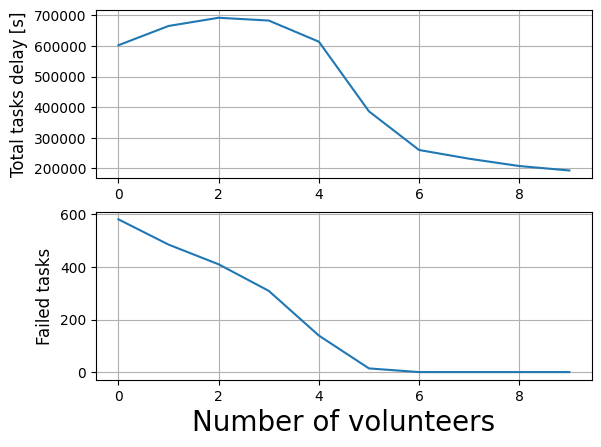

In [17]:
Nvolunteers = 10 # Maximum number of volunteers to use in this test
tasks = randomTaskGenerator(_Ntasks = 1000)
totalTasksDelay = []
Nclouds = 1
Nedges = 2
notAssignedTasks = []
verbose = False

network = randomNetworkGenerator(Nclouds, Nedges)
for Nvol in range(Nvolunteers):
  testNetwork = copy.deepcopy(network)
  testTasks = copy.deepcopy(tasks)
  network.generateRandomVolunteer("volunteer" + str(Nvol))
  simulation = Simulation(testNetwork, testTasks, "computationTime")
  runTimeControl = simulation.run()

  totalTasksDelay.append(simulation.totalTasksDelay())
  notAssignedTasks.append(runTimeControl.getNotAssignedTasks())
  if verbose:
    print("Number of volunteers = ", Nvol)
    print("Total tasks delay = ", simulation.totalTasksDelay())
    print("Number of not assigned tasks = ", runTimeControl.getNotAssignedTasks())
    print("\n")

plt.subplot(2, 1, 1)
plt.ylabel('Total tasks delay [s]', fontsize=12)

plt.grid()
plt.plot(range(Nvolunteers), totalTasksDelay)

plt.subplot(2,1, 2)
plt.ylabel('Failed tasks', fontsize=12)
plt.grid()
plt.plot(range(Nvolunteers), notAssignedTasks)
plt.xlabel('Number of volunteers', fontsize=20)
plt.show()

In [18]:
# Constants for the simulation
Nclouds = 1
Nedges = 5
Nvolunteers = 100
Ntasks = 10000  # Number of tasks to simulate
turnOnFreq = 15  # Constant turn-on frequency for volunteers

# Range of shutdown frequencies to test
shutdown_frequencies = range(5, 51, 5)  # From 5 to 50 with a step of 5

# Lists to store the results
total_task_execution_times = []

# Generate the network and tasks outside the loop (constant for all simulations)
network = randomNetworkGenerator(Nclouds, Nedges)
network.generateRandomVolunteers(Nvolunteers)
tasks = randomTaskGenerator(Ntasks)

# Perform simulations for each shutdown frequency
for shutDownFreq in shutdown_frequencies:
    simulation = Simulation(network, tasks, "computationTime")
    runTimeControl = simulation.runWithRandomShutdowns(shutDownFreq, turnOnFreq)

    # Calculate total task execution time for this shutdown frequency
    total_execution_time = simulation.totalTasksDelay()
    total_task_execution_times.append(total_execution_time)

    # Optionally, reset the network and tasks if necessary for each iteration

# Print the results in text format
print("Dependence of Task Execution Time on Volunteer Shutdown Frequency")
print("------------------------------------------------------------------")
for freq, exec_time in zip(shutdown_frequencies, total_task_execution_times):
    print(f"Shutdown Frequency: {freq}, Total Task Execution Time: {exec_time} seconds")

# Optionally, save the results to a text file for sharing
with open("simulation_results_shutdown_frequency.txt", "w") as file:
    file.write("Dependence of Task Execution Time on Volunteer Shutdown Frequency\n")
    file.write("------------------------------------------------------------------\n")
    for freq, exec_time in zip(shutdown_frequencies, total_task_execution_times):
        file.write(f"Shutdown Frequency: {freq}, Total Task Execution Time: {exec_time} seconds\n")

print("\nResults have also been written to 'simulation_results_shutdown_frequency.txt'")


Dependence of Task Execution Time on Volunteer Shutdown Frequency
------------------------------------------------------------------
Shutdown Frequency: 5, Total Task Execution Time: 1645833.927765 seconds
Shutdown Frequency: 10, Total Task Execution Time: 5544.818421 seconds
Shutdown Frequency: 15, Total Task Execution Time: 145558.08829699995 seconds
Shutdown Frequency: 20, Total Task Execution Time: 108241.48883599997 seconds
Shutdown Frequency: 25, Total Task Execution Time: 11323.717719 seconds
Shutdown Frequency: 30, Total Task Execution Time: 2383.647418 seconds
Shutdown Frequency: 35, Total Task Execution Time: 0 seconds
Shutdown Frequency: 40, Total Task Execution Time: 0 seconds
Shutdown Frequency: 45, Total Task Execution Time: 0 seconds
Shutdown Frequency: 50, Total Task Execution Time: 0 seconds

Results have also been written to 'simulation_results_shutdown_frequency.txt'


In [19]:
pip install memory_profiler


In [20]:
!pip install memory_profiler


In [21]:
%load_ext memory_profiler


In [22]:
import time
from memory_profiler import memory_usage

def run_simulation(number_of_volunteers, number_of_tasks):
    # Placeholder for your simulation code
    pass

def measure_performance(number_of_volunteers, number_of_tasks):
    start_time = time.time()
    peak_memory = max(memory_usage((run_simulation, (number_of_volunteers, number_of_tasks))))
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"Volunteers: {number_of_volunteers}, Tasks: {number_of_tasks}, Execution Time: {execution_time}s, Peak Memory: {peak_memory} MiB")

# Example of measuring performance for different scenarios
measure_performance(10, 1000)
measure_performance(20, 5000)
# Add more scenarios as needed


Volunteers: 10, Tasks: 1000, Execution Time: 0.4397854804992676s, Peak Memory: 194.96875 MiB
Volunteers: 20, Tasks: 5000, Execution Time: 0.2713301181793213s, Peak Memory: 195.2109375 MiB


In [23]:
!pip install memory_profiler
%load_ext memory_profiler

import time
from memory_profiler import memory_usage

# Constants for the base simulation setup
Nclouds = 1
Nedges = 5
initial_volunteers = [10,20,30,40, 50,60,70,80,90,100]  # Different numbers of volunteers to test
tasks_to_simulate = [1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]  # Different numbers of tasks to test

# Lists to store the results
results = []

import time
from memory_profiler import memory_usage

# Assuming Simulation, randomNetworkGenerator, and randomTaskGenerator are defined elsewhere in your notebook

def run_simulation_with_metrics(n_volunteers, n_tasks):
    # Setup the simulation environment
    network = randomNetworkGenerator(Nclouds, Nedges)
    network.generateRandomVolunteers(n_volunteers)
    tasks = randomTaskGenerator(n_tasks)
    simulation = Simulation(network, tasks, "computationTime")  # Adjusted to match expected Simulation initialization

    # Measure execution time and memory usage
    start_time = time.time()
    # Adjust memory_usage call to match how your simulation runs. Assuming .run() doesn't need args here.
    mem_usage = memory_usage((simulation.run, ()), max_usage=True, retval=True)

    execution_time = time.time() - start_time
    peak_memory, _ = mem_usage  # _ would be the return value from simulation.run(), if needed

    return execution_time, peak_memory

# Now, you can loop through your varying numbers of volunteers and tasks as before, calling this adjusted function.


# Testing scalability by varying the number of volunteers and tasks
for n_volunteers in initial_volunteers:
    for n_tasks in tasks_to_simulate:
        execution_time, peak_memory = run_simulation_with_metrics(n_volunteers, n_tasks)
        results.append((n_volunteers, n_tasks, execution_time, peak_memory))
        print(f"Volunteers: {n_volunteers}, Tasks: {n_tasks}, Execution Time: {execution_time:.2f}s, Peak Memory: {peak_memory:.2f} MiB")

# Optionally, save the results to a text file for sharing
with open("simulation_scalability_results.txt", "w") as file:
    file.write("Scalability Test: Number of Volunteers vs Number of Tasks\n")
    file.write("----------------------------------------------------------\n")
    for n_volunteers, n_tasks, exec_time, mem_usage in results:
        file.write(f"Volunteers: {n_volunteers}, Tasks: {n_tasks}, Execution Time: {exec_time:.2f}s, Peak Memory Usage: {mem_usage:.2f} MiB\n")

print("\nScalability test results have also been written to 'simulation_scalability_results.txt'")


The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Volunteers: 10, Tasks: 1000, Execution Time: 0.27s, Peak Memory: 195.42 MiB
Volunteers: 10, Tasks: 2000, Execution Time: 0.64s, Peak Memory: 195.93 MiB
Volunteers: 10, Tasks: 3000, Execution Time: 0.92s, Peak Memory: 196.46 MiB
Volunteers: 10, Tasks: 4000, Execution Time: 1.04s, Peak Memory: 197.01 MiB
Volunteers: 10, Tasks: 5000, Execution Time: 1.58s, Peak Memory: 197.57 MiB
Volunteers: 10, Tasks: 6000, Execution Time: 2.59s, Peak Memory: 198.11 MiB
Volunteers: 10, Tasks: 7000, Execution Time: 2.25s, Peak Memory: 198.67 MiB
Volunteers: 10, Tasks: 8000, Execution Time: 2.31s, Peak Memory: 199.23 MiB
Volunteers: 10, Tasks: 9000, Execution Time: 0.91s, Peak Memory: 199.84 MiB
Volunteers: 10, Tasks: 10000, Execution Time: 1.84s, Peak Memory: 200.40 MiB
Volunteers: 20, Tasks: 1000, Execution Time: 0.78s, Peak Memory: 200.42 MiB
Volunteers: 20, Tasks: 2000, Execution Time: 0.32s, Peak Memory: 

### Volunteers shut down test

In [24]:


Nclouds = 1
Nedges = 2
Nvolunteers = 10

network = randomNetworkGenerator(Nclouds, Nedges)
network.generateRandomVolunteers(Nvolunteers)

tasks = randomTaskGenerator(_Ntasks = 1000)

simulation = Simulation(network, tasks, "computationTime")

shutDownFreq = 20
turnOnFreq = 15
runTimeControl = simulation.runWithRandomShutdowns(shutDownFreq, turnOnFreq)
simulation.plotGanttChart()
network.print()
print("\nNumber of not assigned tasks = ", runTimeControl.getNotAssignedTasks())
print("Simulation1 total tasks delay = %d s" % simulation.totalTasksDelay())


Network structure:
cloud_0
edge_0
edge_1
myDevice
volunteer_0
	Availability =  1
	Trust =  0.8499999999999999
volunteer_1
	Availability =  1
	Trust =  0.4608718487394958
volunteer_2
	Availability =  1
	Trust =  0.6215334805466276
volunteer_3
	Availability =  1
	Trust =  0.9333333333333333
volunteer_4
	Availability =  1
	Trust =  0.5779688418577307
volunteer_5
	Availability =  1
	Trust =  0.9375
volunteer_6
	Availability =  1
	Trust =  0.4131944444444444
volunteer_7
	Availability =  1
	Trust =  0.7757575757575758
volunteer_8
	Availability =  1
	Trust =  0.7529411764705881
volunteer_9
	Availability =  1
	Trust =  0.7472527472527474

Number of not assigned tasks =  0
Simulation1 total tasks delay = 283743 s
